### Audio Classification Data Inspector, Feature Extraction Document
In this document we will read in our data set:
* read in all our audio data, train and test
* inspect the diversity of the audio data
* Then perform feature extraction and cache as a NPY file for MFCC and Mel-Spectrogram.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import helper
import os
import math 

# reproducibility
np.random.seed(42)

### Dataset Read In
In this section we will read in our data set structure which is located in our home holder

```
root:
    kaggle_2018_dataset:
        train:
            wav files for training only, contains catalog.csv
        test:
            wav files for testing our model, contains catalog.csv
        data:
            npy files, feature extraction MFCC and MEL-SPEC
        models:
            trained models
```

In [2]:
# get the data set root directory path
dataset_root_dir = os.path.join("/home/charlesedwards/Documents", 'kaggle_2018_dataset')

# get the train and test data directories
train_dir = os.path.join(dataset_root_dir, 'train')
test_dir = os.path.join(dataset_root_dir, 'test')

# get the catalog.csv for train and test directories
train_catalog_csv = os.path.join(train_dir, 'catalog.csv')
test_catalog_csv = os.path.join(test_dir, 'catalog.csv')

# read the catalog.csv files
train_metadata = pd.read_csv(train_catalog_csv)
test_metadata = pd.read_csv(test_catalog_csv)

# drop unwanted columns 
train_metadata.drop(['license','freesound_id'], axis=1, inplace=True)
test_metadata.drop(['license','freesound_id'], axis=1, inplace=True)

# display the first 5 rows of both metadatas
helper.display_side_by_side([train_metadata.head(),test_metadata.head()], ['train_metadata', 'test_metadata'])

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1
,fname,label,usage
0,00326aa9.wav,Oboe,Private
1,0038a046.wav,Bass_drum,Private
2,007759c4.wav,Saxophone,Private
3,008afd93.wav,Saxophone,Private


In [3]:
print(len(train_metadata.index))
# merge train_metadata and test_metadata
metadata = pd.concat([train_metadata, test_metadata])
print(len(metadata.index))
metadata.head()

9473
11073


,fname,label,manually_verified,usage
0,00044347.wav,Hi-hat,0.0,NaN
1,001ca53d.wav,Saxophone,1.0,NaN
2,002d256b.wav,Trumpet,0.0,NaN
3,0033e230.wav,Glockenspiel,1.0,NaN
4,00353774.wav,Cello,1.0,NaN


### Visualize Label Distribution 
In this section of the notebook we will display the label distribution i.e number of audio files per class

Minimum samples per category =  120
Maximum samples per category =  410


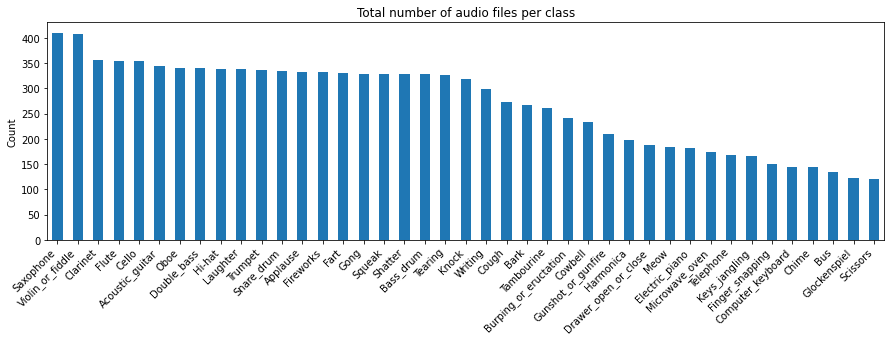

In [4]:
# # visualize the label count distribution
# plt.figure(figsize=(15,4))
# chart = train_metadata['label'].value_counts().plot(kind='bar',)
# chart.set_xticklabels(labels=chart.get_xticklabels(), rotation=45, horizontalalignment='right')
# chart.set_title("Total number of audio files per class")
# chart.set_ylabel('Count')

# print('Minimum samples per category = ', min(train_metadata['label'].value_counts()))
# print('Maximum samples per category = ', max(train_metadata['label'].value_counts()))

# visualize the label count distribution
plt.figure(figsize=(15,4))
chart = metadata['label'].value_counts().plot(kind='bar',)
chart.set_xticklabels(labels=chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set_title("Total number of audio files per class")
chart.set_ylabel('Count')

print('Minimum samples per category = ', min(metadata['label'].value_counts()))
print('Maximum samples per category = ', max(metadata['label'].value_counts()))

### Visualize Verified Label Distribution 
In this section of the notebook we will display how many labels are verified vs not

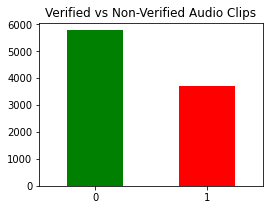

In [5]:
plt.figure(figsize=(4,3))

# plot the number of manually_verified vs non manually_verified audio clips
verified_count = train_metadata['manually_verified'].value_counts()
verified_count.plot(kind='bar', color=['green', 'red'], rot=0, title='Verified vs Non-Verified Audio Clips')


In [6]:
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/20),
                       min_periods=1,
                       center=True).max()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask, y_mean

import wavio
from librosa.core import resample, to_mono

def downsample_mono(path, sr):
    obj = wavio.read(path)
    wav = obj.data.astype(np.float32, order='F')
    rate = obj.rate
    try:
        channel = wav.shape[1]
        if channel == 2:
            wav = to_mono(wav.T)
        elif channel == 1:
            wav = to_mono(wav.reshape(-1))
    except IndexError:
        wav = to_mono(wav.reshape(-1))
        pass
    except Exception as exc:
        raise exc
    wav = resample(wav, rate, sr)
    wav = wav.astype(np.int16)
    return sr, wav

### Read Audio To Memory
This process will take a lot of ram and may vary on dataset size. Atm a 5GB dataset uses roughly 12GB of ram

In [7]:
# # Windowing
# n_fft=1024
# hop_length=512
def load_data_set(data_dir="TEST AND TRAIN MERGED",metadata_pd=None, sample_rate=22050):

    processed_data = []
    sample_rates = []
    durations = []

    print(f"Processing audio from: {data_dir} ... with {len(metadata_pd)} files\n")

    length = len(metadata_pd)
    counter = 0
    process_step = 0

    # using librosa for every fname in our data_frame generate a mel spectrogram and save it to a numpy array
    for x, row in enumerate(metadata_pd.iloc):
        
        target_file = ""
        # detect if row["usage"] is NaN
        #print(str(row["usage"]).lower())
        if str(row["usage"]).lower() == "nan":
            # if nan its a test train
            target_file = os.path.join( train_dir, row['fname'] )
        else:
            target_file = os.path.join( test_dir, row['fname'] )

        # load the audio file
        # y, sr = librosa.load( target_file, sr=sample_rate, mono=True)

        # # re sample the audio data to a lower sample rate
        # #y_22k = librosa.resample(y, orig_sr=sr, target_sr=22050)

        sr, y = downsample_mono(target_file, sample_rate)
        
        # normalize the audio with librosa
        #y = librosa.util.normalize(y)

        # append the data to our processed_data array
        processed_data.append(y)
        sample_rates.append(sr)
        #durations.append(librosa.get_duration(y=y, sr=sr))

        # Notify update every N files
        if (counter == 500):
            process_step += counter
            print("Status: {}/{}".format(process_step+1, length))
            counter = 0

        counter += 1


    print("done")

    print("appending to processed_data as column 'data'")
    # append the processed_data to the data frame as data
    metadata_pd["data"] = processed_data
    print("done")

    print("appending to sample_rates as column 'sr'")
    # append the sample_rates to the data frame as sr
    metadata_pd["sr"] = sample_rates
    print("done")

    # print("appending to durations as column 'duration'")
    # # append the sample_rates to the data frame as sr
    # metadata_pd["duration"] = durations
    # print("done")


In [8]:
# # load in the train data set
# load_data_set(train_dir, train_metadata, max_duration=None)

# # load in the test data set
# load_data_set(test_dir, test_metadata, max_duration=None)

load_data_set(metadata_pd=metadata)

Processing audio from: TEST AND TRAIN MERGED ... with 11073 files

Status: 501/11073
Status: 1001/11073
Status: 1501/11073
Status: 2001/11073
Status: 2501/11073
Status: 3001/11073
Status: 3501/11073
Status: 4001/11073
Status: 4501/11073
Status: 5001/11073
Status: 5501/11073
Status: 6001/11073
Status: 6501/11073
Status: 7001/11073
Status: 7501/11073
Status: 8001/11073
Status: 8501/11073
Status: 9001/11073
Status: 9501/11073
Status: 10001/11073
Status: 10501/11073
Status: 11001/11073
done
appending to processed_data as column 'data'
done
appending to sample_rates as column 'sr'
done


In [9]:
# display the first 5 rows of both metadatas again as we now have normalized audio data
#helper.display_side_by_side([train_metadata.head(),test_metadata.head()], ['train_metadata', 'test_metadata'])
metadata.head()

,fname,label,manually_verified,usage,data,sr
0,00044347.wav,Hi-hat,0.0,NaN,"[1641, 1545, -4681, -3984, -1651, 19155, -2023...",22050
1,001ca53d.wav,Saxophone,1.0,NaN,"[-6127, -9225, -8852, -10220, -9954, -9460, -6...",22050
2,002d256b.wav,Trumpet,0.0,NaN,"[-16, -270, -393, -102, -191, -149, -91, -374,...",22050
3,0033e230.wav,Glockenspiel,1.0,NaN,"[-5636, 5361, -11370, 455, -27726, -9597, 1636...",22050
4,00353774.wav,Cello,1.0,NaN,"[-32067, 20481, 28313, 28408, -29637, -32139, ...",22050


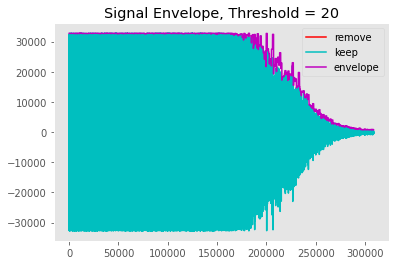

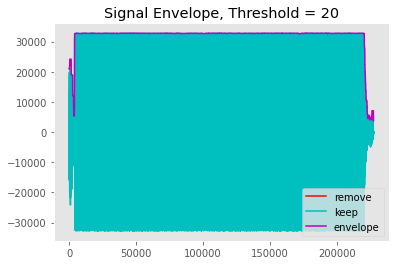

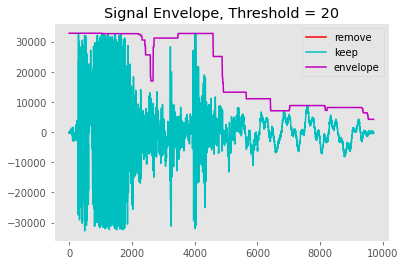

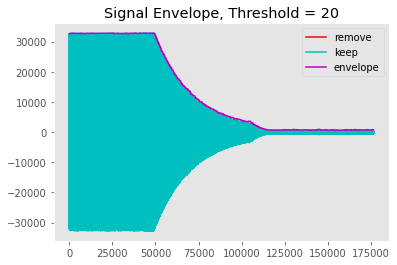

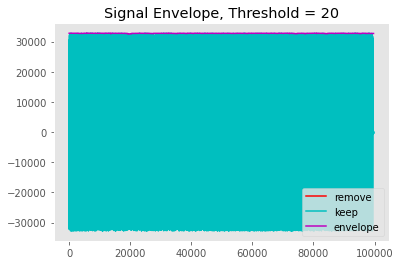

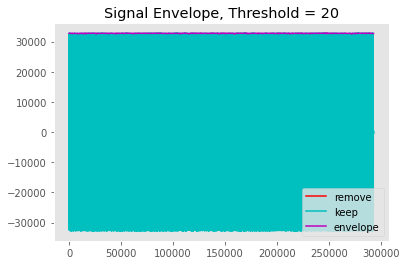

In [11]:
threshold = 20

# test cleanup first 6 files
for i in range(6):

    data = metadata.iloc[i]['data']

    mask, env = envelope(data, metadata.iloc[i]['sr'], threshold=threshold)
    plt.style.use('ggplot')
    plt.title('Signal Envelope, Threshold = {}'.format(str(threshold)))
    plt.plot(data[np.logical_not(mask)], color='r', label='remove')
    plt.plot(data[mask], color='c', label='keep')
    plt.plot(env, color='m', label='envelope')
    plt.grid(False)
    plt.legend(loc='best')
    plt.show()

In [14]:
DELTA_TIME = 1
def cache_cleaned_files(metadata_pd,base_name=None):

    if base_name is None:
        print("base_name is None")
        return

    base_name = 'cache-' + base_name

    print(f"Starting creation of cache for base name: {base_name} total, {len(metadata_pd)} files")

    # Iterate through all audio files and extract MFCC
    features = []
    labels = []

    counter = 0
    total_samples = len(metadata_pd)
    frames_max = 0

    for index, row in metadata_pd.iterrows():
        class_label = row["label"]
        SAMPLE_RATE = row['sr']
        #TRACK_DURATION = row['duration']

        wav = row['data'] 
        mask, y_mean = envelope(wav, SAMPLE_RATE, threshold=threshold)
        wav = wav[mask]

        delta_sample = int(DELTA_TIME*SAMPLE_RATE)

        # cleaned audio is less than a single sample
        # pad with zeros to delta_sample size
        if wav.shape[0] < delta_sample:
            sample = np.zeros(shape=(delta_sample,), dtype=np.int16)
            sample[:wav.shape[0]] = wav

            features.append(sample)
            labels.append(class_label)
        # step through audio and save every delta_sample
        # discard the ending audio if it is too short
        else:
            trunc = wav.shape[0] % delta_sample
            for cnt, i in enumerate(np.arange(0, wav.shape[0]-trunc, delta_sample)):
                start = int(i)
                stop = int(i + delta_sample)
                sample = wav[start:stop]
                features.append(sample)
                labels.append(class_label)

        # Notify update every N files
        if (counter == 500):
            print("Status: {}/{}".format(index+1, total_samples))
            counter = 0

        counter += 1
    
    # Convert features (X) and labels (y) to Numpy arrays
    X = np.array(features)#padded_features # np.array(padded_features)
    y = np.array(labels)

    data_npy_folder = os.path.join(dataset_root_dir, 'data')

    # Optionally save the features to disk
    np.save( os.path.join(data_npy_folder, f"X-{base_name}" ), X)
    np.save( os.path.join(data_npy_folder, f"y-{base_name}" ), y)

    # free up memory
    del X
    del y
    del features
    del labels
    
    print(f"Finished creation of cache for features for base name: {base_name} total, {len(metadata_pd)} files")
    return frames_max
    

In [15]:
cache_cleaned_files(metadata, base_name='merged')

Starting creation of cache for base name: cache-merged total, 11073 files
Status: 501/11073
Status: 1001/11073
Status: 1501/11073
Status: 2001/11073
Status: 2501/11073
Status: 3001/11073
Status: 3501/11073
Status: 4001/11073
Status: 4501/11073
Status: 5001/11073
Status: 5501/11073
Status: 6001/11073
Status: 6501/11073
Status: 7001/11073
Status: 7501/11073
Status: 8001/11073
Status: 8501/11073
Status: 9001/11073
Status: 28/11073
Status: 528/11073
Status: 1028/11073
Status: 1528/11073
Finished creation of cache for features for base name: cache-merged total, 11073 files


0

In [9]:
# # get the average duration of all audio clips in the pd data frame
# print("Average duration of all audio TRAIN clips: {}".format(np.mean(train_metadata['duration'])))

# print("Average duration of all audio TEST clips: {}".format(np.mean(test_metadata['duration'])))

# # get the lowest and highest duration of all audio clips in the pd data frame
# print("Lowest duration of all audio TRAIN clips: {}".format(np.min(train_metadata['duration'])))

# print("Highest duration of all audio TRAIN clips: {}".format(np.max(train_metadata['duration'])))


# # merged data
# # get the average duration of all audio clips in the pd data frame
# print("Average duration of all audio TRAIN clips: {}".format(np.mean(metadata['duration'])))

# print("Average duration of all audio TEST clips: {}".format(np.mean(metadata['duration'])))

# # get the lowest and highest duration of all audio clips in the pd data frame
# print("Lowest duration of all audio TRAIN clips: {}".format(np.min(metadata['duration'])))

# print("Highest duration of all audio TRAIN clips: {}".format(np.max(metadata['duration'])))